In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
### load data from csv
data_imdb = pd.read_csv("data/imdb_data.csv")
data_rotten = pd.read_csv("data/rotten_tomatoes_movie_reviews.csv")

In [4]:
# EDA imdb data
data_imdb.columns
print(data_imdb.head())

Index(['review', 'sentiment'], dtype='object')

In [5]:
# EDA rotten data
data_rotten.columns
print(data_rotten.head())

Index(['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic',
       'originalScore', 'reviewState', 'publicatioName', 'reviewText',
       'scoreSentiment', 'reviewUrl'],
      dtype='object')

In [10]:
# Drop columns not needed from rotten data
data_rotten = data_rotten[["reviewText", "scoreSentiment"]]

In [6]:
# Get an overview of imdb sentiment split
print(data_imdb["sentiment"].value_counts())
# Equally positive and negative, which helps reduce bias

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [12]:
# Get an overview of rotten sentiment split
print(data_rotten["scoreSentiment"].value_counts())

scoreSentiment
POSITIVE    963799
NEGATIVE    481164
Name: count, dtype: int64


In [ ]:
# IMDB data is balanced, while rotten data is not -> Rotten data will need to be balanced to be used in training

In [15]:
# Check for missing values
print(data_imdb.isnull().sum())
print(data_rotten.isnull().sum())

review       0
sentiment    0
dtype: int64
reviewText        0
scoreSentiment    0
dtype: int64


In [14]:
# Rotten data has missing values -> Need to be dropped before training
data_rotten.dropna(inplace=True)

In [16]:
# Rename columns to text and label to keep data consistent
data_imdb.rename(columns={"review": "text", "sentiment": "label"}, inplace=True)
data_rotten.rename(columns={"reviewText": "text", "scoreSentiment": "label"}, inplace=True)

In [17]:
# Apply tokenization and preprocessing to both datasets to get a better understanding of word distribution
from tools.data_preprocess import ClassicPreprocessorSpacy
preprocessor = ClassicPreprocessorSpacy()
data_imdb["tokens"] = preprocessor.transform(data_imdb["text"])
data_rotten["tokens"] = preprocessor.transform(data_rotten["text"])
print(data_imdb.head())
print(data_rotten.head())

                                                text     label  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                              tokens  
0  [reviewer, mention, watch, oz, episode, hook, ...  
1  [wonderful, little, production, filming, techn...  
2  [think, wonderful, way, spend, time, hot, summ...  
3  [basically, family, little, boy, jake, think, ...  
4  [petter, mattei, love, time, money, visually, ...  
                                                text     label  \
0  Timed to be just long enough for most youngste...  POSITIVE   
1  It doesn't matter if a movie costs 300 million...  NEGATIVE   
2  The choreography is so precise and lifelike at...  POSITIVE   
3  The fi

In [22]:
# Show empty tokens that may be created by preprocessing
print(len(data_imdb[data_imdb["tokens"].apply(lambda x: len(x) == 0)]))
print(len(data_rotten[data_rotten["tokens"].apply(lambda x: len(x) == 0)]))

0
488


In [ ]:
# 488 empty tokens in rotten data, which need to be dropped

In [23]:
# Get overview of why preprocessing creates empty tokens (short reviews only containing stop words, non alphabetic characters)
print(data_rotten[data_rotten["tokens"].apply(lambda x: len(x) == 0)])

                                                      text  label tokens
4398                                                   1.5      0     []
4752                                Enough is enough&#46;       0     []
5239                             A pleasure&#46;&#46;&#46;      1     []
7905     %u03B7 %u03C0%u03C1%u03BF%u03C3%u03C0%u03AC%u0...      0     []
10216    Trauma&#44; warts&#44; fame&#44; and family&#4...      1     []
...                                                    ...    ...    ...
1437312  He was an heir&#46; She was a dom&#46; Can I m...      1     []
1439247                              Not for everyone&#46;      1     []
1441575                               Same as it ever was.      0     []
1442788                         I'm just not that into it.      0     []
1444688  When it&apos;s a &apos;Thor&apos; movie&#44; i...      0     []

[488 rows x 3 columns]


In [24]:
# Drop empty tokens
data_rotten = data_rotten[data_rotten["tokens"].apply(lambda x: len(x) > 0)]

In [18]:
# Turn sentiment into binary to allow model to understand
data_imdb["label"] = data_imdb["label"].apply(lambda x: 1 if x == "positive" else 0)
data_rotten["label"] = data_rotten["label"].apply(lambda x: 1 if x == "POSITIVE" else 0)

In [19]:
# Count word/ token occurrences in imdb data
from collections import Counter
word_count_imdb = Counter()
for i in range(data_imdb.shape[0]):
    word_count_imdb.update(data_imdb["tokens"][i])
# Create table of word counts
word_counts_df_imdb = pd.DataFrame.from_dict(word_count_imdb, orient="index", columns=["count"])
word_counts_df_imdb = word_counts_df_imdb.sort_values(by="count", ascending=False)

print(word_counts_df_imdb.head(10))


            count
movie      100844
film        93192
like        43855
good        40391
time        30475
character   27846
watch       27215
bad         26003
story       24696
see         24477


In [26]:
# Count word/ token occurrences in rotten data
# reset index to avoid key error
data_rotten.reset_index(drop=True, inplace=True)
word_count_rotten = Counter()
for i in range(data_rotten.shape[0]):
    word_count_rotten.update(data_rotten["tokens"][i])
# Create table of word counts
word_counts_df_rotten = pd.DataFrame.from_dict(word_count_rotten, orient="index", columns=["count"])
word_counts_df_rotten = word_counts_df_rotten.sort_values(by="count", ascending=False)

print(word_counts_df_rotten.head(10))

              count
film         272864
movie        178687
good          97208
like          96165
story         89785
time          66253
character     65901
feel          58657
performance   57994
work          52933


In [ ]:
# Similar words are most present in both datasets, which is expected

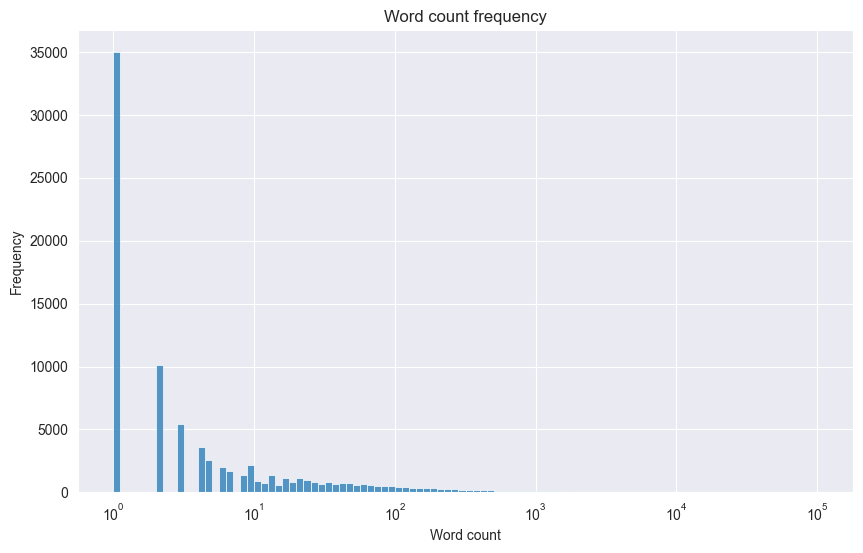

In [27]:
# Plot occurrence of words in imdb data
plt.figure(figsize=(10, 6))
sns.histplot(word_counts_df_imdb["count"], bins=100, log_scale=True)
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.title("Word count frequency")
plt.show()


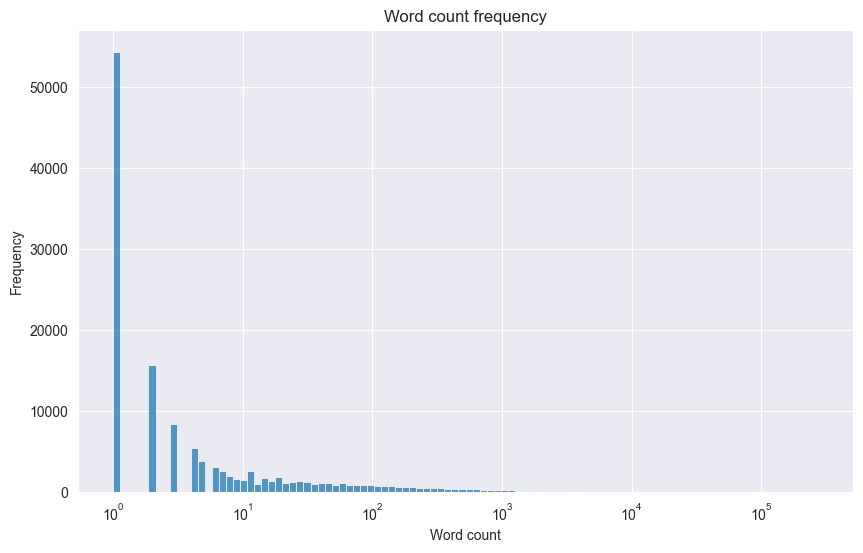

In [28]:
# Plot occurrence of words in rotten data
plt.figure(figsize=(10, 6))
sns.histplot(word_counts_df_rotten["count"], bins=100, log_scale=True)
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.title("Word count frequency")
plt.show()

In [ ]:
# Similarly shaped distribution, with most words occurring only a few times


In [42]:
# Calculate total number of tokens and unique tokens in imdb data
total_tokens_imdb = sum(word_counts_df_imdb["count"])
total_unique_tokens_imdb = word_counts_df_imdb.shape[0]
print(f"Total unique tokens: {total_unique_tokens_imdb}")
print(f"Total tokens: {total_tokens_imdb}")


Total unique tokens: 84742
Total tokens: 5011153


In [45]:
# Calculate total number of tokens and unique tokens in rotten data
total_tokens_rotten = sum(word_counts_df_rotten["count"])
total_unique_tokens_rotten = word_counts_df_rotten.shape[0]
print(f"Total unique tokens: {total_unique_tokens_rotten}")
print(f"Total tokens: {total_tokens_rotten}")

Total unique tokens: 133846
Total tokens: 15211718


In [ ]:
# Rotten data has more unique tokens, which is expected in a larger dataset

In [34]:
# Check how many words occur over 10% of the time in imdb data
print(len(word_counts_df_imdb[word_counts_df_imdb["count"] > 0.1 * data_imdb.shape[0]]))


117


In [36]:
# Check how many words occur over 10% of the time in rotten data
print(len(word_counts_df_rotten[word_counts_df_rotten["count"] > 0.1 * data_rotten.shape[0]]))

2


In [ ]:
# rotten data has only 2 words that occur over 10% of the time, which is very low

In [43]:
# Check how many words occur only once in imdb data
only_once_imdb = len(word_counts_df_imdb[word_counts_df_imdb["count"] == 1])
print(only_once_imdb)
print(only_once_imdb / total_unique_tokens_imdb*100)


34978
41.275872648745604


In [46]:
# Check how many words occur only once in rotten data
only_once_rotten = len(word_counts_df_rotten[word_counts_df_rotten["count"] == 1])
print(only_once_rotten)
print(only_once_rotten / total_unique_tokens_rotten*100)

54284
40.55705811156105


In [ ]:
# Similar percentage of words that occur only once in both datasets around 41%
# These words dont provide much information for training

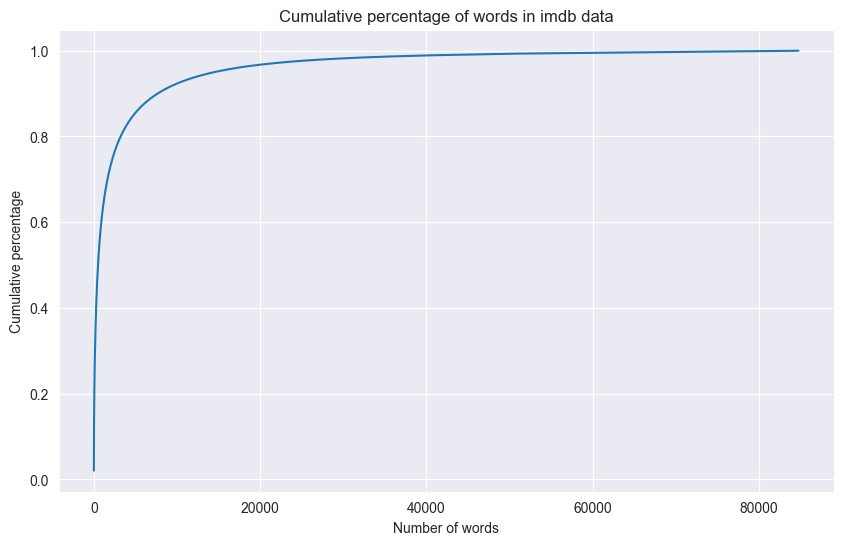

In [54]:
# Check cumulative percentage of top 10000 words in imdb data
cumulative_imdb = word_counts_df_imdb["count"].cumsum() / total_tokens_imdb
# create cumulative distribution chart
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, total_unique_tokens_imdb+1), y=cumulative_imdb)
plt.xlabel("Number of words")
plt.ylabel("Cumulative percentage")
plt.title("Cumulative percentage of words in imdb data")
plt.show()

0.9131674016044736


C:\Users\vince\AppData\Local\Temp\ipykernel_2196\2067560859.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(cumulative_rotten[10000])


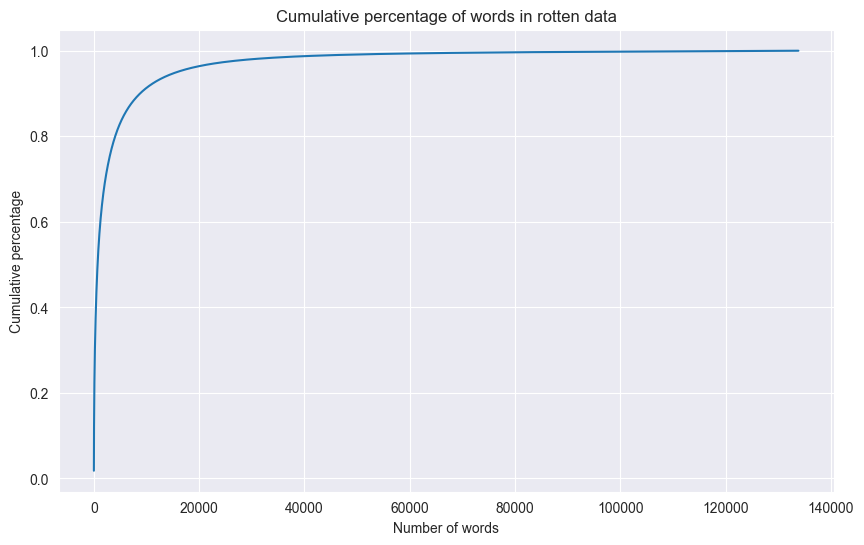

In [55]:
# Check cumulative percentage of top 10000 words in rotten data
cumulative_rotten = word_counts_df_rotten["count"].cumsum() / total_tokens_rotten
print(cumulative_rotten[10000])
# create cumulative distribution chart
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, total_unique_tokens_rotten+1), y=cumulative_rotten)
plt.xlabel("Number of words")
plt.ylabel("Cumulative percentage")
plt.title("Cumulative percentage of words in rotten data")
plt.show()

In [ ]:
# over 90% of tokens are covered by the top 10000 words in both datasets -> vectorizer maximum features can be set to 10000

In [56]:
# Check how many tokens cover 80% of the data in imdb data
print(len(cumulative_imdb[cumulative_imdb < 0.8]))


3216


In [57]:
# Check how many tokens cover 80% of the data in rotten data
print(len(cumulative_rotten[cumulative_rotten < 0.8]))

4050


In [ ]:
# 3200 tokens carry 80% of the information in imdb data, while 4000 tokens carry 80% of the information in rotten data
# -> try vectorizers with around 4000 features